### Recommended literature for FRESEAN mode analysis

M. A. Sauer & M. Heyden, *J. Chem. Theory Comput.* **2023**, 19, 5481-5490.

### Import modules

In [1]:
import os
import urllib.request
# numpy makes python fast
import numpy as np
# MDAnalysis provides an interface to many topology and trajectory formats
import MDAnalysis as mda
from MDAnalysis.analysis.dihedrals import Dihedral
# tqdm gives us progress bars
from tqdm import *
# Fourier transforms from scipy
from scipy.fft import fft, ifft
# matplotlib for plotting
import matplotlib.pyplot as plt
# custom modules (included)
import unwrap as pbc
import align as fit
import graphics as g # custom module for 2D and 3D graphics

### System setup

<details>
    <summary>Description of user input</summary>

>   - if needed, download input files
>   - create MDAnalysis Universe
>   - create atom selection
>   - set number of constraints applied to selection
>   - provide reference coordinates
>   - define number of time steps in correlation functions
>   - define time step between frames saved in trajectory
>   - determine width of Gaussian window for spectra convolution

</details>

In [2]:
def download_if_needed(filename, url):
    if not os.path.exists(filename):
        print(f"{filename} not found. Downloading from {url} ...")
        urllib.request.urlretrieve(url, filename)
        print(f"Downloaded {filename}.")

# We will now analyze a simulation of alanine dipeptide in the gas phase at 300K. 
# Due to the increased temperature, the molecule is now more easily able to explore its conformational space.
# We thus expect anharmonic effects to be much more pronounced, including:
# 1) coexistence of multiple conformations (with their own vibrations)
# 2) anharmonic coupling between modes (cross correlations and energy transfer)
# 3) significant deviations of the actual vibrations from harmonic normal modes
download_if_needed("data/MD-gas-300K/topol.tpr", "https://www.dropbox.com/scl/fi/zux7notw4x9omhqj1rngj/topol.tpr?rlkey=svz7x62n0g4sooee10vp968zp&dl=1")
download_if_needed("data/MD-gas-300K/traj.trr", "https://www.dropbox.com/scl/fi/vhbtq7x3vqdap5t3i0vlw/traj.trr?rlkey=cffmtm0tysiy85bd3luaa46af&dl=1")
u = mda.Universe("data/MD-gas-300K/topol.tpr","data/MD-gas-300K/traj.trr")

# select the atoms used for analysis (trajectories provided here contain only atoms from alanine dipeptide)
sel = u.select_atoms("all")
# center of mass translation and rotation is removed during the MD to avoid the flying ice-cube effect
nConstraints = 6 # constraints applied to atoms in selection
# if you have specific reference coordinates for the alignment, define them here
# otherwise leave 'altRefPos' as None when creating the instance of fit.align()
# -> in that case, the first time frame of the trajecotry will be used
uRef = mda.Universe("data/harmonic-normal-modes/min.xyz")
align = fit.align(u, sel, rotVel=1, placeCOMInBox=0, altRefPos=uRef.atoms.positions)
# define correlation time, time step in trajectory and Gaussian window size
nCorr = 500 # in time frames
dt = 0.004 # in ps
sigma = 10.0 # in cm**-1

align: WARNING:
 -> no box dimensions in trajectory
 -> using cubic (100 A)**3 box as dummy


### Setup analysis

In [3]:
unwrap = pbc.unwrap(u) # make all molecules whole

# len of trajectory needed to allocate arrays
nFrames = len(u.trajectory)
# number of atoms in selection
nAtoms = sel.n_atoms
# number of degrees of freedom (DOF) in selection
nDOF = nAtoms * 3 - nConstraints
# allocate arrays to store atomic velocities
velocities = np.zeros((nAtoms * 3, nFrames), dtype=np.complex128)
# store square root of atomic masses for each DOF
sqm = np.repeat(np.sqrt(sel.atoms.masses), 3)

# define Gaussian window for FFT
# - frequency resolution in cm**-1
wn0 = 1.0 / ((2 * nCorr -1) * dt) * 33.3564
# - frequency range for spectra
freqs = np.arange(nCorr) * wn0
# normalization factor for Gaussian window function in frequency domain
winNorm = 1.0 / np.sqrt(2.0 * np.pi * sigma**2)
# - array to store Gaussian window (in time and frequency domain)
winFreq = np.zeros(2 * nCorr - 1)
winTime = np.zeros(2 * nCorr - 1)
# create Gaussian window in frequency domain
# - first half is Gaussian, second half is a mirror image
# - this is to ensure that the window is real-valued in the time domain
winFreq[0:nCorr] = winNorm * np.exp(-0.5 * freqs**2 / sigma**2)
winFreq[nCorr:] = winFreq[nCorr-1:0:-1]
# generate the Gaussian window in time domain
winTime = np.real(ifft(winFreq))

# allocate the velocity correlation matrix
corrMatrix = np.empty((nCorr, nAtoms * 3, nAtoms * 3))

### Loop over trajectory

- unwrap periodic boundary conditions if needed
- perform translational/rotational alignment (rotate velocities)
- store $\sqrt{m} \cdot \tilde{\mathrm{v}}(t)$ for all atoms in selection

In [4]:
for i, ts in enumerate(tqdm(u.trajectory)):
    unwrap.single_frame()
    align.single_frame()
    velocities[:, i] = sqm * sel.velocities.flatten()

  0%|          | 491/250001 [00:00<00:50, 4906.03it/s]

unwrap: WARNING:
 -> no box dimensions available!
 -> skipping unwrap!


100%|██████████| 250001/250001 [00:43<00:00, 5690.82it/s]


## **FREquency-SElective ANharmonic (FRESEAN) mode analysis: Part 1**

### **Computing the velocity correlation matrix $\mathbf{C}_{\tilde{\mathrm{v}}}$**

see <font style="font-family: courier; color: cyan">01-tutorial_MD-gas-50K.ipynb</font> for details

In [5]:
# Fourier transform of velocities (Eq. 2)
velocities = fft(velocities, axis=1)

# arrays for temporary data storage
tmp1 = np.zeros(nFrames, dtype=np.float64)
tmp2 = np.zeros(nFrames, dtype=np.float64)
tmp3 = np.zeros(2 * nCorr -1, dtype=np.float64)
# loop over all correlation matrix elements
for i in tqdm(range(nAtoms * 3)):
    for j in range(i, nAtoms * 3):
        # one element of correlation matrix
        # multiply Fourier transformed velocities (Eq. 3)
        # and enforce real-valued result (Eq. 4)
        tmp1 = np.real(velocities[i] * velocities[j].conj())
        # transform from frequency into time domain (Eq. 5)
        tmp2 = np.real(ifft(tmp1))
        # cut off time domain data after tau_max = nCorr * dt
        tmp3[:nCorr] = tmp2[:nCorr]
        # enforce time symmetry of truncated time correlation function
        tmp3[nCorr:] = tmp2[nCorr-1:0:-1]
        # multiply with Gaussian window function in time domain (Eq. 8)
        tmp3 *= winTime
        # and Fourier transform into frequency domain (Eq. 8)
        corrMatrix[:,i, j] = np.real(fft(tmp3)[:nCorr])
        if i != j:
            # use symmetry of correlation matrix
            corrMatrix[:, j, i] = corrMatrix[:, i, j]
# correct for implicit multiplication in power spectrum
corrMatrix /= nFrames
# free memory used to store velocities and temporary data
del velocities, tmp1, tmp2, tmp3

100%|██████████| 66/66 [00:21<00:00,  3.10it/s]


## **FRESEAN mode analysis: Part 2**

### **Computing eigenvectors an eigenvalues**

see <font style="font-family: courier; color: cyan">01-tutorial_MD-gas-50K.ipynb</font> for details


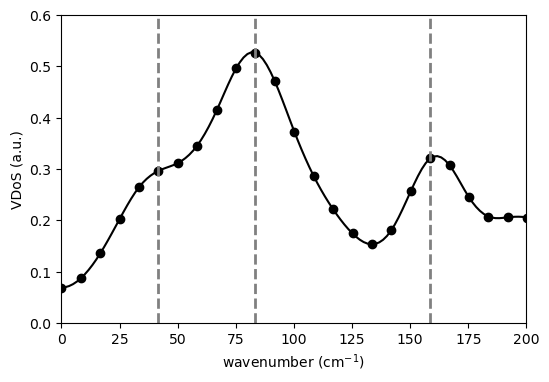

In [6]:
eigenvalues = []
eigenvectors = []
for i in range(nCorr):
    vals, vecs = np.linalg.eigh(corrMatrix[i])
    # sort eigenvalues and eigenvectors in descending order
    idx = np.argsort(vals)[::-1] # indices for descending order
    vals = vals[idx]
    vecs = vecs[:, idx]
    eigenvalues.append(vals)
    # Note: access i'th eigenvector as vecs.T[i]
    eigenvectors.append(vecs.T) # transpose to have eigenvectors as rows
# convert lists to numpy arrays
eigenvalues = np.array(eigenvalues)
eigenvectors = np.array(eigenvectors)

# here we compute the average temperature of the system
# we consider some of the idiosyncracies of symmetrized and discretized data
avgTemp = (np.sum(eigenvalues[0]) + 2 * np.sum(eigenvalues[1:])) / (2 * nCorr - 1) / winTime[0] / (8.3145 * 0.1) / nDOF
# this normalization factor for eigenvalues and the corrMatrix ensures that simple sums over VDoS (ignoring symmetry) roughly the corresponding number of DOF
VDoSnorm = nCorr * winTime[0] * (8.3145 * 0.1 * avgTemp)

# normalize eigenvalues and corrMatrix
eigenvalues /= VDoSnorm
corrMatrix /= VDoSnorm

# total VDoS (Eq. 10 avove)
VDoStot = np.sum(eigenvalues, axis=1)
# find peaks in total VDoS
peakIndices = np.where((VDoStot[1:-1] > VDoStot[:-2]) & (VDoStot[1:-1] > VDoStot[2:]))[0] + 1
peakIndices = np.array([5] + peakIndices.tolist())
# peak frequencies
peakFreqs = freqs[peakIndices]

# total vibrational density of states below 200 wavenumbers
g.plotSpectra(freqs, 
            VDoStot, 
            xlim=[0,200], 
            ylim=[0,0.6], 
            vlines = freqs[peakIndices].tolist(),
            filename='figures/MD-gas-300K_totalVDoS.png')

The total vibrational density of states at 300K has only two peaks in the low-frequency range (at least with the 10 $\mathrm{cm}^{-1}$ Gaussian window).  
Above, we manually added the frequency of the low-frequency shoulder at approximately 40 $\mathrm{cm}^{-1}$ to the list of peak frequencies. Alternatively, if we decrease the width of the Gaussian window, we will resolve the shoulder as a separate peak.

Just like for the low-temperature simulation, we will focus our following analysis on these peak frequencies.

### **Analyzing contributions to selected peaks in the total VDoS**

Just like in the low temperature simulation, we will use FRESEAN mode analysis to identify vibrational modes contributing to the total VDoS at the selected peak frequencies (or any other sampled frequency). In the following, we will analyze the 4 vibrational modes that contribute the most to the total VDoS at the selected peak frequencies.

see <font style="font-family: courier; color: cyan">01-tutorial_MD-gas-50K.ipynb</font> for details

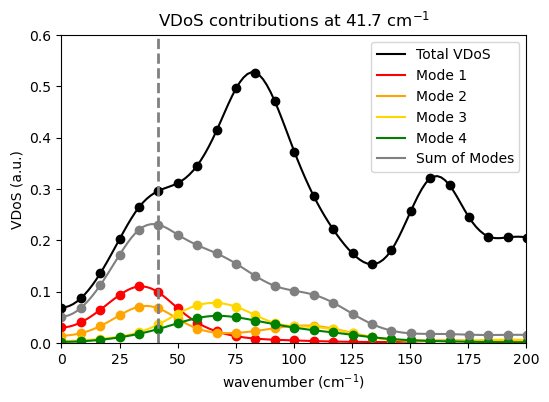

In [7]:
# select low-frequency peaks below 200 wavenumbers
lowFreqPeakIndices = peakIndices[np.where(peakFreqs < 200)[0]]
nLowFreqPeaks = len(lowFreqPeakIndices)
# select number of most important modes to be extracted for each low-frequency peak
nModes = 4
# Selected eigenvectors (vibrational modes) with largest VDoS contribution at each low-frequency peak
lowFreqVibModes = eigenvectors[lowFreqPeakIndices,0:nModes]
# 1D-VDoS for four most contributing vibrational modes at each low-frequency peak
# (see Eq. 11)
lowFreqModesVDoS = np.zeros((nLowFreqPeaks, nModes, nCorr))
for p in range(nLowFreqPeaks):
    for m in range(nModes):
        for i in range(nCorr):
            lowFreqModesVDoS[p, m, i] = np.dot(lowFreqVibModes[p, m], np.dot(corrMatrix[i], lowFreqVibModes[p, m]))

# plot 1D-VDoS of vibrational modes contributing most at selected low-frequency peak
lowFreqPeakIndex = 0 # = 0,1,2 : choose between the peaks in the low-frequency VDoS
g.plotSpectra(freqs,
            [VDoStot] + [arr for arr in lowFreqModesVDoS[lowFreqPeakIndex]] + [np.sum(lowFreqModesVDoS[lowFreqPeakIndex], axis=0)],
            xlim=[0,200], 
            ylim=[0,0.6], 
            colors=['black', 'red', 'orange', 'gold', 'green', 'gray'],
            labels=['Total VDoS', 'Mode 1', 'Mode 2', 'Mode 3', 'Mode 4', 'Sum of Modes'],
            filename='figures/MD-gas-300K_peak-' + f"{lowFreqPeakIndex+1}" + '-modes-VDoS.png',
            vlines = freqs[lowFreqPeakIndices[lowFreqPeakIndex]],
            title = "VDoS contributions at " + f"{freqs[lowFreqPeakIndices[lowFreqPeakIndex]]:.1f}" + " cm$^{-1}$")

Feel free to change the `lowFreqPeakIndex` above (choose 0, 1 or 2) to analyze the main contributions to the other low-frequency peaks in the VDoS. Compared to the 50K simulation, we observe much wider peak and shallower peaks (the integral of each 1D-VoS is identical: 1 DOF). This is characteristic of a molecule that explores more than the local environment of a potential energy minimum.

Again, visualizing the eigenvalues directly gives us an alternative way to judge how many vibrational modes are contributing to the VDoS at each frequency. Below, we plot the first 10 eigenvalues for each low-frequency peak in the total VDoS.

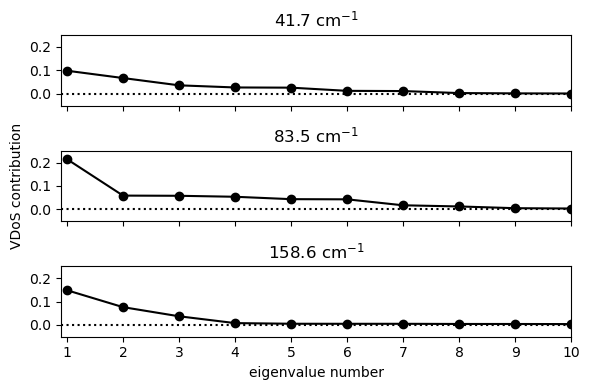

In [8]:
fig, axs = plt.subplots(nLowFreqPeaks, 1, figsize=(6,nLowFreqPeaks * 4/3), sharex=True)

for idx, ax in enumerate(axs):
    ax.plot(range(1, 10 + 1), eigenvalues[lowFreqPeakIndices[idx]][0:10], color='black')
    ax.plot(range(1, 10 + 1), eigenvalues[lowFreqPeakIndices[idx]][0:10], 'o', color='black')
    ax.set_xlim(0.9, 10)
    ax.set_ylim(-0.05, 0.25)
    ax.set_title(f"{freqs[lowFreqPeakIndices[idx]]:.1f} cm$^{{-1}}$")
    hlines = ax.axhline(0, color='black', linestyle=':')
    ax.set_yticks(ticks=np.arange(0.0,0.3,1/10), labels=[f"{x:.1f}" for x in np.arange(0.0,0.3,1/10)])
plt.xticks(ticks=range(1, 10 + 1), labels=range(1, 10 + 1))
axs[-1].set_xlabel("eigenvalue number")
axs[1].set_ylabel("VDoS contribution")
plt.tight_layout()
plt.savefig('figures/MD-gas-300K_lowFreqPeaks-eigenvalues.png', dpi=300)
plt.show()

Compared to the simulation at 50K, we can see that individual eigenvalues are smaller (as are the peak intensities in the 1D-VDoS), the number of non-zero eigenvalues for a given frequency has increased. In other words, we need to consier more types of vibrations to explain the total VDoS at each peak frequency. 

This is expected, e.g., for a molecule that visits multiple conformations, which exhibit distinct vibrations with overlapping spectra. In FRESEAN mode analysis, we only use a reference structure to eliminate changes in the coordinate system due to rigid body rotations. Beyond that, the analysis is performed entirely based on velocities and independent of the underlying coordinates.

If multiple conformations with distinct vibrational modes contribute to the total VDoS at a specific frquency, we can detect them as separate vibrational modes with non-zero eigenvalues. The underlying structures are only needed, if we aim to visualize the vibrations. We will save this part for the next notebook, in which we analyze a simulation of alanine dipeptide in solution.

As before, we can use Eq. 11 to compute correlation functions between any two distinct degrees of freedom in the frequency domain. We then symmetrize and perform an inverse Fourier transform to get the corresponding time auto and cross corerlation functions.

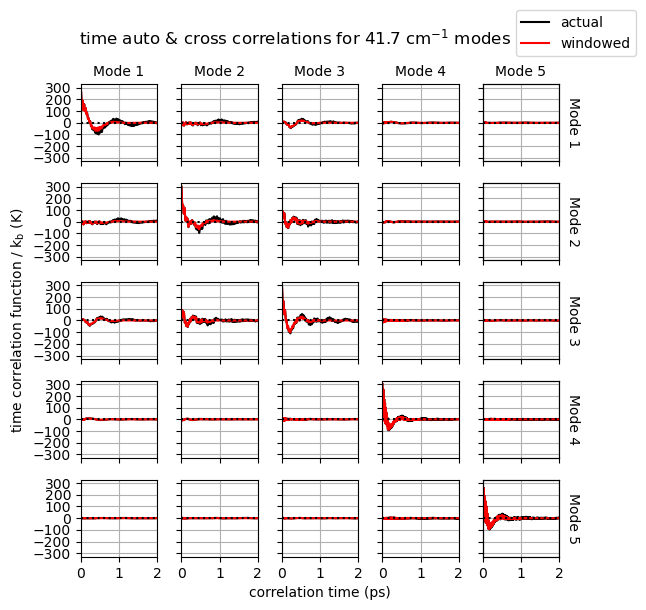

In [9]:
# select low frequency peak for time correlation analysis
# Note: we are not limited to analyzing correlations between vibrational modes at the same frequency
lowFreqPeakIndex = 0 # = 0,1,2 : choose between the peaks in the low-frequency VDoS
idx = lowFreqPeakIndices[lowFreqPeakIndex]
times = np.arange(nCorr) * dt
tmp1 = np.zeros(2 * nCorr - 1, dtype=np.float64)

fig, axs = plt.subplots(5, 5, figsize=(6,6), sharex=True, sharey=True)
for i, axrow in enumerate(axs):
    for j, ax in enumerate(axrow):
        for k in range(nCorr):
            tmp1[k] = np.dot(eigenvectors[idx, i], np.dot(corrMatrix[k], eigenvectors[idx, j]))
        tmp1[nCorr:] = tmp1[nCorr-1:0:-1]
        # convert to mode temperature
        vcf = np.real(ifft(tmp1))[:nCorr] * avgTemp * nCorr
        # if i != j:
        #     vcf *= 2
        #     ax.text(0.98, 0.9, 'x2', color='green', fontsize=16, ha='right', va='center', transform=ax.transAxes)
        # else:
        #     ax.text(0.98, 0.9, 'x1', color='black', fontsize=16, ha='right', va='center', transform=ax.transAxes)
        # remove window function entirely
        vcfActual = vcf / winTime[:nCorr] * winTime[0]
        ax.plot(times, vcfActual, color='black', label='actual')
        ax.plot(times, vcf, color='red', label='windowed')
        ax.set_xlim(0,2)
        ax.set_ylim(-330, 330)
        hlines = ax.axhline(0, color='black', linestyle=':')

axs[-1][2].set_xlabel("correlation time (ps)")
axs[2][0].set_ylabel(r"time correlation function / k$_{{\mathrm{b}}}$ (K)")
plt.suptitle(f"time auto & cross correlations for {freqs[idx]:.1f} cm$^{{-1}}$ modes")
for ax in axs.flat:
    ax.label_outer()
    ax.grid(True)
for ax in axs.flat:
    ax.set_xticks(np.arange(0, 3, 1))
    ax.set_yticks(np.arange(-300, 301, 100))
    ax.set_aspect('auto')
    ax.grid(True)
for i, ax in enumerate(axs[0]):
    ax.set_title(f"Mode {i+1}", fontsize=10)
for i, ax in enumerate(axs[:,4]):
    ax2 = ax.twinx()
    ax2.set_ylabel(f"Mode {i+1}", rotation=270, va='center', ha='center', fontsize=10, labelpad=10)
    ax2.set_yticks([])
plt.tight_layout()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.08, 1.02))
plt.savefig('figures/MD-gas-300K_peak-' + f"{lowFreqPeakIndex+1}" + '-5x5-time-correlations.png', dpi=300)
plt.show()

Again, feel free to change the `lowFreqPeakIndex` above (choose 0, 1 or 2) to analyze the correlations between vibrational modes contributing to the VDoS at the other low-frequency peaks.

Note that cross correlations between vibrational modes are more pronounced than at low temperature. Such an exchange of vibrational energy is expected for anharmonic vibrations. For example, if the molecule switches from one conformation to another with a new set of vibrations at the analyzed frequency, the energy of the vibrations from the old conformation will transfer into the new ones.

### **Finding key anharmonic vibrations**

As before, we perform a clustering operation between all ow-frequency vibrations. First, we compute a correlation matrix, which describe the pairwise similarity of two vibrations while weighting these correlations with the corresponding eigenvalues.

We restate that this goes beyond FRESEAN mode analysis and just provides a simple example on how to condense the information provided by it.

see <font style="font-family: courier; color: cyan">01-tutorial_MD-gas-50K.ipynb</font> for details

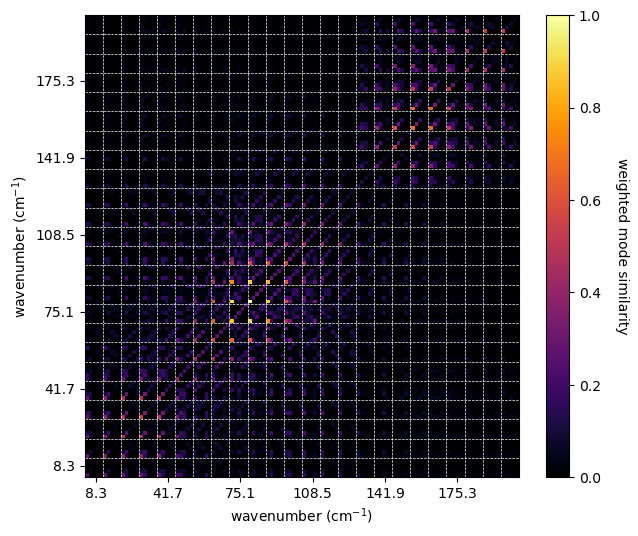

In [10]:
# select eigenvectors and eigenvalues for frequencies below 200 cm$^{-1}$
freqSelIndices = np.where((freqs > 0) & (freqs < 201))[0]
eigenvectorsSel = []
eigenvaluesSel = []
for i in freqSelIndices:
    for m in range(5):
        eigenvaluesSel.append(eigenvalues[i, m])
        eigenvectorsSel.append(eigenvectors[i, m])
eigenvectorsSel = np.array(eigenvectorsSel)
eigenvaluesSel = np.array(eigenvaluesSel)
maxEigenvalue = np.max(eigenvaluesSel)
nSel = len(eigenvaluesSel)

# construct a weighted comparison matrix (see Eq. 12)
clusterMatrix = np.zeros((nSel, nSel), dtype=np.float64)
for i in range(nSel):
    if eigenvaluesSel[i] > 0:
        a = np.sqrt(eigenvaluesSel[i])
    else:
        a = 0.0
    for j in range(nSel):
        if eigenvaluesSel[j] > 0:
            b = np.sqrt(eigenvaluesSel[j])
        else:
            b = 0.0
        clusterMatrix[i, j] = a*b/maxEigenvalue*np.abs(np.dot(eigenvectorsSel[i], eigenvectorsSel[j]))

# plot the weighted comparison matrix
plt.figure(figsize=(7, 6))
im = plt.imshow(clusterMatrix, aspect='auto', cmap='inferno', vmin=0, vmax=1)
cbar = plt.colorbar(im)
cbar.set_label('weighted mode similarity', rotation=270, labelpad=20)
plt.xlabel('wavenumber (cm$^{-1}$)')
plt.ylabel('wavenumber (cm$^{-1}$)')
for l in range(5,125,5):
    plt.axhline(l-0.5, color='white', linestyle='--', linewidth=0.5)
    plt.axvline(l-0.5, color='white', linestyle='--', linewidth=0.5)
plt.gca().invert_yaxis()
plt.xticks(ticks=np.arange(2.5,117.6,20), labels=np.round(freqs[1:24:4],1))
plt.yticks(ticks=np.arange(2.5,117.6,20), labels=np.round(freqs[1:24:4],1))
plt.savefig('figures/MD-gas-300K_clustering-matrix.png', dpi=300)
plt.show()

As before, this matrix contains information on how many unique vibrational modes we detected in the low-frequency range of alanine dipeptide.

#### Clustering of low-frequency vibrations

see <font style="font-family: courier; color: cyan">01-tutorial_MD-gas-50K.ipynb</font> for details

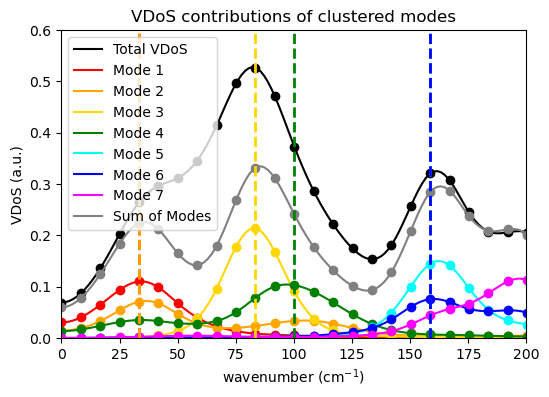

In [11]:
cutoff = 0.3
clusterIndices = []
matrix = clusterMatrix.copy()
if np.max(matrix) > cutoff:
    while True:
        # counts the number of elements in each row that are larger than the cutoff
        row_counts = np.sum(matrix > cutoff, axis=1)
        max_count = np.max(row_counts)
        # if no row has elements larger than the cutoff, break the loop
        if max_count == 0:
            break
        # find the row with the larger number of elements larger than the cutoff
        # this index corresponds to the center of a cluster of similar modes
        # (Note: I avoid the use of np.argmax() here to emulate the exact behavior of a previous implementation of this algorithm in Mathematica)
        max_row_index = np.where(row_counts == max_count)[0][-1]
        # add index to the list of clusters
        clusterIndices.append(max_row_index)
        # find indices of all the elements in the selected row that are larger than the cutoff
        # these are the cluster members and need to be removed from the matrix
        indices_to_remove = np.where(matrix[max_row_index] > cutoff)[0]
        # for all members of current cluster, remove rows and columns from the matrix (set entries to 0)
        matrix[:, indices_to_remove] = 0
        matrix[indices_to_remove, :] = 0
# select the eigenvectors and eigenvalues for the cluster centers
clusterIndices = np.array(clusterIndices)
nClusterModes = len(clusterIndices)
eigenvectorsCluster = eigenvectorsSel[clusterIndices]
eigenvaluesCluster = eigenvaluesSel[clusterIndices]

# compute the 1D-VDoS for the clustered vibrational modes (Eq. 11)
VDoSclusterModes = np.zeros((nClusterModes, 25))
for m in range(nClusterModes):
    for i in range(25):
        VDoSclusterModes[m, i] = np.dot(eigenvectorsCluster[m], np.dot(corrMatrix[i], eigenvectorsCluster[m]))

# find the peaks in the 1D-VDoS of clustered vibrational modes
# sort the clustered eigenvectors, eigenvalues, and their 1D-VDoS according to their peak frequency
peak_indices_cluster_modes = np.argmax(VDoSclusterModes, axis=1)
sort_indices = np.argsort(peak_indices_cluster_modes)
peak_indices_cluster_modes = peak_indices_cluster_modes[sort_indices]
clusterIndices = clusterIndices[sort_indices]
eigenvectorsCluster = eigenvectorsCluster[sort_indices]
eigenvaluesCluster = eigenvaluesCluster[sort_indices]
VDoSclusterModes = VDoSclusterModes[sort_indices]

# plot 1D-VDoS of clustered vibrational modes
# to keep things consistent, we plot the 1D-VDoS for the first 7 clustered modes (largest clusters)
g.plotSpectra(freqs[0:25],
            [VDoStot[0:25]] + [arr for arr in VDoSclusterModes[0:7]] + [np.sum(VDoSclusterModes[0:nClusterModes], axis=0)],
            xlim=[0,200], 
            ylim=[0,0.6], 
            colors=['black', 'red', 'orange', 'gold', 'green', 'cyan', 'blue', 'magenta', 'gray'],
            labels=['Total VDoS', 'Mode 1', 'Mode 2', 'Mode 3', 'Mode 4', 'Mode 5', 'Mode 6', 'Mode 7', 'Sum of Modes'],
            filename='figures/MD-gas-300K_anharmonic-modes-VDoS.png',
            vlines = freqs[peak_indices_cluster_modes[0:7]].tolist(),
            vlineColors = ['red', 'orange', 'gold', 'green', 'cyan', 'blue', 'magenta'],
            title = "VDoS contributions of clustered modes")

Through clustering (with the same cutoff as in the low-temperature simulation), we again find 7 important vibrations in the low-frequency spectrum of alanine dipeptide.

Interestingly, modes 1, 4 and 6 have peak frequencies similar to vibrations identified at low temperature. However, peak intensities in the corresponding 1D-VDoS are significantly smaller and the peaks broader. Further, modes 2 and 4 now have bimodal spectra and the sum over the seven modes provides a much less complete representation of the total VDoS in the 50-125 $\mathrm{cm}^{-1}$ range.
Thus, to describe the low-frequency VDoS of alanine dipeptide, we need to include additional vibrations. 

We note that the results can be quite sensitive to the cutoff parameter. Other clustering algorithms may provide a more stable solution. Significant overlap/similarity between clustered vibrational modes must be avoided. Otherwise, the sum over corresponding 1D-VDoS can be larger than the total VDoS (intensities of non-orthogonal modes are double-counted). 

#### Comparing anharmonic vibrational modes

see <font style="font-family: courier; color: cyan">01-tutorial_MD-gas-50K.ipynb</font> for details

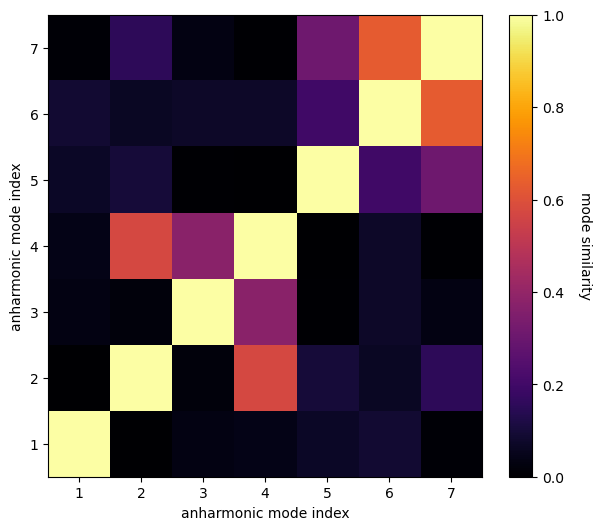

In [12]:
# compute comparison matrix between clustered vibrational modes
compareMatrix = np.zeros((nClusterModes,nClusterModes), dtype = np.float64)
for i in range(nClusterModes):
    for j in range(nClusterModes):
        compareMatrix[i,j] = np.abs(np.dot(eigenvectorsCluster[i],eigenvectorsCluster[j]))

# plot the comparison matrix
plt.figure(figsize=(7, 6))
im = plt.imshow(compareMatrix, aspect='auto', cmap='inferno', vmin=0, vmax=1)
n_ticks = compareMatrix.shape[0]
cbar = plt.colorbar(im)
cbar.set_label('mode similarity', rotation=270, labelpad=20)
plt.xlabel('anharmonic mode index')
plt.ylabel('anharmonic mode index')
plt.gca().invert_yaxis()
plt.xticks(ticks=np.arange(n_ticks), labels=np.arange(1, n_ticks + 1))
plt.yticks(ticks=np.arange(n_ticks), labels=np.arange(1, n_ticks + 1))
plt.savefig('figures/MD-gas-300K_anharmonic-modes-comparison-matrix.png', dpi=300)
plt.show()

Only eigenvectors obtained from $\mathbf{C}_{\tilde{v}}(\omega)$ at the same frequency are guaranteed to be orthogonal. Our clustering algorithm selected eigenvectors of $\mathbf{C}_{\tilde{v}}(\omega)$ at different frequencies, which are thus not guaranteed to be orthogonal. In comparison to low temperatures, we now find more overlap between the clustered vibrational modes. In principle, we could cluster further into 3-5 super clusters: Mode 1, Modes 2 & 4, Mode 3 (minor overlap with Mode 4), Mode 5 (minor overlap with Modes 6 & 7), and Modes 6 & 7.

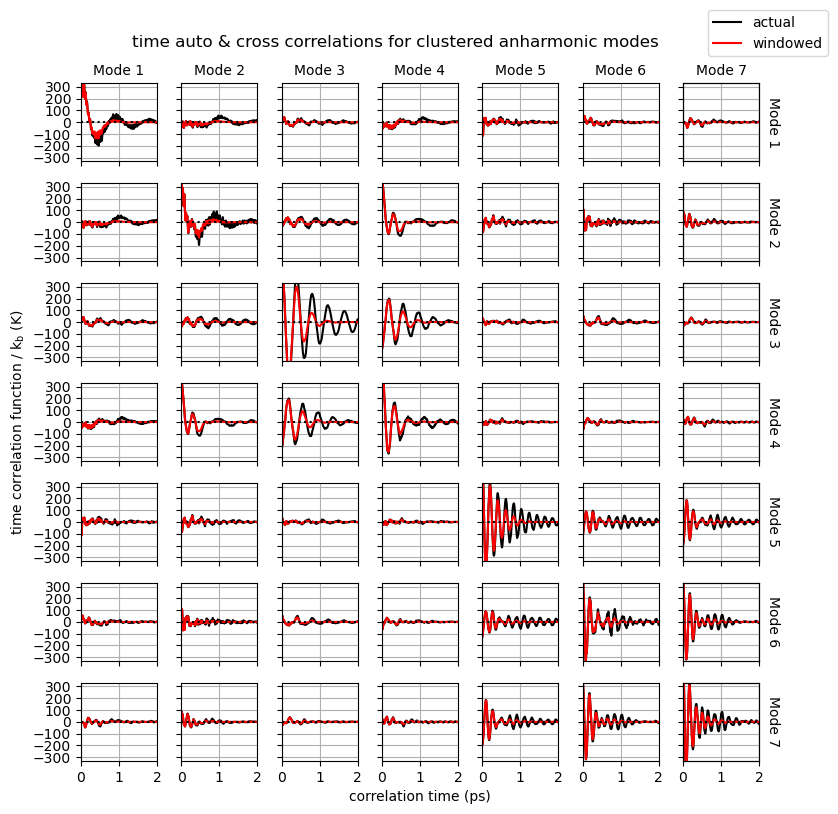

In [13]:
times = np.arange(nCorr) * dt
tmp1 = np.zeros(2 * nCorr - 1, dtype=np.float64)

fig, axs = plt.subplots(7, 7, figsize=(8,8), sharex=True, sharey=True)
for i, axrow in enumerate(axs):
    for j, ax in enumerate(axrow):
        for k in range(nCorr):
            tmp1[k] = np.dot(eigenvectorsCluster[i], np.dot(corrMatrix[k], eigenvectorsCluster[j]))
        tmp1[nCorr:] = tmp1[nCorr-1:0:-1]
        # remove scaling from window function, divide by kB, convert units and correct for symmetry
        vcf = np.real(ifft(tmp1))[:nCorr] * avgTemp * (2 * nCorr -1)
        # if i != j:
        #     vcf *= 2
        #     ax.text(0.98, 0.9, 'x2', color='green', fontsize=16, ha='right', va='center', transform=ax.transAxes)
        # else:
        #     ax.text(0.98, 0.9, 'x1', color='black', fontsize=16, ha='right', va='center', transform=ax.transAxes)
        # remove window function entirely
        vcfActual = vcf / winTime[:nCorr] * winTime[0]
        ax.plot(times, vcfActual, color='black', label='actual')
        ax.plot(times, vcf, color='red', label='windowed')
        ax.set_xlim(0,2)
        ax.set_ylim(-330, 330)
        hlines = ax.axhline(0, color='black', linestyle=':')

axs[-1][3].set_xlabel("correlation time (ps)")
axs[3][0].set_ylabel(r"time correlation function / k$_{{\mathrm{b}}}$ (K)")
plt.suptitle(f"time auto & cross correlations for clustered anharmonic modes")
for ax in axs.flat:
    ax.label_outer()
    ax.grid(True)
for ax in axs.flat:
    ax.set_xticks(np.arange(0, 3, 1))
    ax.set_yticks(np.arange(-300, 301, 100))
    ax.set_aspect('auto')
    ax.grid(True)
for i, ax in enumerate(axs[0]):
    ax.set_title(f"Mode {i+1}", fontsize=10)
for i, ax in enumerate(axs[:,6]):
    ax2 = ax.twinx()
    ax2.set_ylabel(f"Mode {i+1}", rotation=270, va='center', ha='center', fontsize=10, labelpad=10)
    ax2.set_yticks([])
plt.tight_layout()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1.02))
plt.savefig('figures/MD-gas-300K_anharmonic-modes-7x7-time-correlations.png', dpi=300)
plt.show()

We find much larger cross correlations between the identified vibrational modes compared to low temperatures. This is expected given the high temperature and thus increased anharmonic behavior as well as the increased overlap between modes. In particular, we expect (and observe) cross correlations at correlation times tau = 0 that are proportional to the overlap between vibrational modes.

### Comparison to harmonic normal modes

see <font style="font-family: courier; color: cyan">01-tutorial_MD-gas-50K.ipynb</font> for details

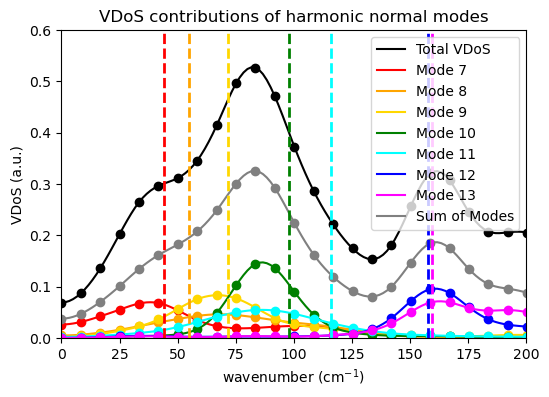

In [14]:
# generating data sets for plots
# importing harmonic normal modes for comparison
harmonic = mda.Universe("data/harmonic-normal-modes/eigenvec.xyz","data/harmonic-normal-modes/eigenvec.xyz")
harmonicModes = np.zeros((3 * nAtoms, 3 * nAtoms), dtype=np.float64)
for m in range(3 * nAtoms):
    harmonicModes[m] = harmonic.trajectory[m].positions.flatten()
# 1D-VDoS for all harmonic normal modes
# computed with Eq. 11 above
VDoSharmonicModes = np.zeros((3 * nAtoms, nCorr))
for m in range(3 * nAtoms):
    for i in range(nCorr):
        VDoSharmonicModes[m, i] = np.dot(harmonicModes[m], np.dot(corrMatrix[i], harmonicModes[m]))
# Import harmonic frequencies
harmonicFreqs = np.loadtxt('data/harmonic-normal-modes/eigenfreq.dat', comments='#')[:,1]

# plot 1D-VDoS of harmonic normal modes 7-12 (omit modes 1-6, which describe tranlations/rotations)
g.plotSpectra(freqs,
            [VDoStot] + [arr for arr in VDoSharmonicModes[6:13]] + [np.sum(VDoSharmonicModes[6:13], axis=0)],
            xlim=[0,200], 
            ylim=[0,0.6], 
            colors=['black', 'red', 'orange', 'gold', 'green', 'cyan', 'blue', 'magenta', 'gray'],
            labels=['Total VDoS', 'Mode 7', 'Mode 8', 'Mode 9', 'Mode 10', 'Mode 11', 'Mode 12', 'Mode 13', 'Sum of Modes'],
            filename='figures/MD-gas-300K_harmonic-modes-VDoS.png',
            vlines = harmonicFreqs[6:13].tolist(),
            vlineColors = ['red', 'orange', 'gold', 'green', 'cyan', 'blue', 'magenta'],
            title = "VDoS contributions of harmonic normal modes")

With the exception of harmonic mode 4 and 6, the spectra observed in the 1D-VDoS result in very broad peaks. In comparison, the 1D-VDoS obtained after clustering results from FRESEAN mode analysis results in narrower, more well-defined peaks. This indicates that the vibrations at this simulation temperature deviate quite significantly from the harmonic approximations. 

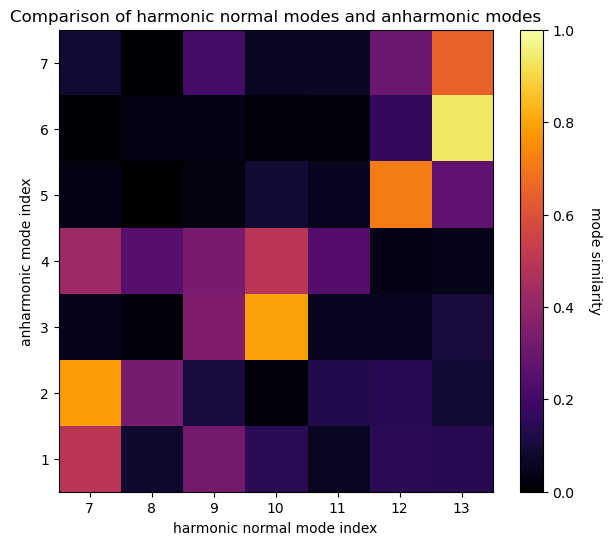

In [15]:
# compute comparison matrix between clustered vibrational modes and harmonic normal Modes
compareMatrix = np.zeros((nClusterModes,nClusterModes), dtype = np.float64)
for i in range(nClusterModes):
    for j in range(nClusterModes):
        compareMatrix[i,j] = np.abs(np.dot(eigenvectorsCluster[i],harmonicModes[j+6]))

# plot the comparison matrix
plt.figure(figsize=(7, 6))
im = plt.imshow(compareMatrix, aspect='auto', cmap='inferno', vmin=0, vmax=1)
n_ticks = compareMatrix.shape[0]
cbar = plt.colorbar(im)
cbar.set_label('mode similarity', rotation=270, labelpad=20)
plt.xlabel('harmonic normal mode index')
plt.ylabel('anharmonic mode index')
plt.gca().invert_yaxis()
plt.xticks(ticks=np.arange(n_ticks), labels=np.arange(1, n_ticks + 1) + 6)
plt.yticks(ticks=np.arange(n_ticks), labels=np.arange(1, n_ticks + 1))
plt.title('Comparison of harmonic normal modes and anharmonic modes')
plt.savefig('figures/MD-gas-300K_harmonic-anharmonic-modes-comparison-matrix.png', dpi=300)
plt.show()

For the low temperature simulation, we still observed substantial similarity between harmonic normal modes and the vibrational modes obtained from clustering the FRESEAN mode analysis results. This is much less the case here. Only 4 harmonic normal modes (7, 10, 12, 13) have significant overlap with the anharmonic vibrational modes detected from the simulation.

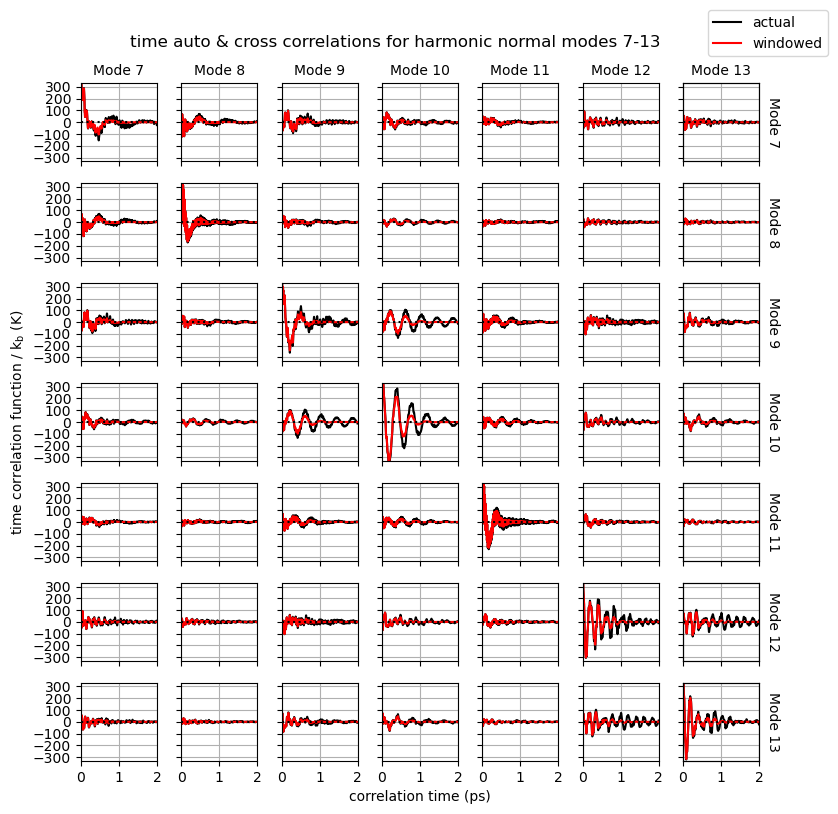

In [16]:
times = np.arange(nCorr) * dt
tmp1 = np.zeros(2 * nCorr - 1, dtype=np.float64)

fig, axs = plt.subplots(7, 7, figsize=(8,8), sharex=True, sharey=True)
for i, axrow in enumerate(axs):
    for j, ax in enumerate(axrow):
        for k in range(nCorr):
            tmp1[k] = np.dot(harmonicModes[i+6], np.dot(corrMatrix[k], harmonicModes[j+6]))
        tmp1[nCorr:] = tmp1[nCorr-1:0:-1]
        # remove scaling from window function, divide by kB, convert units and correct for symmetry
        vcf = np.real(ifft(tmp1))[:nCorr] * avgTemp * (2 * nCorr -1)
        # if i != j:
        #     vcf *= 2
        #     ax.text(0.98, 0.9, 'x2', color='green', fontsize=16, ha='right', va='center', transform=ax.transAxes)
        # else:
        #     ax.text(0.98, 0.9, 'x1', color='black', fontsize=16, ha='right', va='center', transform=ax.transAxes)
        # remove window function entirely
        vcfActual = vcf / winTime[:nCorr] * winTime[0]
        ax.plot(times, vcfActual, color='black', label='actual')
        ax.plot(times, vcf, color='red', label='windowed')
        ax.set_xlim(0,2)
        ax.set_ylim(-330, 330)
        hlines = ax.axhline(0, color='black', linestyle=':')

axs[-1][3].set_xlabel("correlation time (ps)")
axs[3][0].set_ylabel(r"time correlation function / k$_{{\mathrm{b}}}$ (K)")
plt.suptitle(f"time auto & cross correlations for harmonic normal modes 7-13")
for ax in axs.flat:
    ax.label_outer()
    ax.grid(True)
for ax in axs.flat:
    ax.set_xticks(np.arange(0, 3, 1))
    ax.set_yticks(np.arange(-300, 301, 100))
    ax.set_aspect('auto')
    ax.grid(True)
for i, ax in enumerate(axs[0]):
    ax.set_title(f"Mode {i+7}", fontsize=10)
for i, ax in enumerate(axs[:,6]):
    ax2 = ax.twinx()
    ax2.set_ylabel(f"Mode {i+7}", rotation=270, va='center', ha='center', fontsize=10, labelpad=10)
    ax2.set_yticks([])
plt.tight_layout()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1.02))
plt.savefig('figures/MD-gas-300K_harmonic-modes-7x7-time-correlations.png', dpi=300)
plt.show()

Apart from excpected cross correlations, the auto correlations show indications of multiple overlapping frequencies (which matches the broad peaks in the 1D-VDoS). This is another indication that the vibrations in the simulated trajectory deviate singificantly from the harmonic model.

## **Vibrational Mode Visualization**

In the following, we can visualize vibrational modes. Importantly, the eigenvectors of either $\mathbf{C}_{\tilde{\mathrm{v}}}(\omega)$ or the mass-weighted Hessian matrix require scaling prior to visualization. 

This is usually done automatically by most programs that visualize vibrational modes. The easiest way to show this is by computing the dot products between the eigenvectors of a given matrix. If the vectors are not orthonormal, they have been modified.

To convert eigenvector components into displacements suitable for visualization, we scale them with $1/\sqrt{m}$, where $m$ is the mass of the corresponding atom.

We begin by (re-)loading our reference structure, which we will use to visualize the atomic displacement vectors described by the eigenvectors of $\mathbf{C}_{\tilde{v}}(\omega)$ or the harmonic normal modes.

Once you are done, continue with <font style="font-family: courier; color: cyan">03-tutorial_MD-water-300K.ipynb</font>

#### **NOTE:** 

The molecule is sampling multiple conformations in this simulation trajectory. This is not necessarily a problem for FRESEAN mode analysis as it will find vibrational modes for any conformation observed in the simulation (we just obtain a larger number of non-zero eigenvalues at each frequency).

However, the visualization of atomic displacements will only make sense with respect to the conformation associated with that vibration. This requires additional analysis of the sampled conformations, which we will skip here.

For the next tutorial, the simulation in solution, we will combine FRESEAN mode analysis with a structural analysis of solute conformations. Specifically, we will perform our analysis for stretches of the trajectory in which the molecule remains in one conformation. We will therefore be able to extract a suitable reference structure to visualize the naharmonic vibrational modes.

In [17]:
uVis = mda.Universe("data/MD-gas-300K/topol.tpr","data/harmonic-normal-modes/min.xyz")
selVis = uVis.select_atoms("all")

In [18]:
# harmonic normal mode visualization
# mode number (any value between 1 and 66 = 3 * nAtoms)
# harmonic normal modes 1-6 describe translations/rotations (or linear combinations thereof)
modeNumber = 4
print(f"Selected harmonic mode {modeNumber} at frequency {harmonicFreqs[modeNumber-1]:.1f} cm$^{-1}$")
disp = np.reshape(harmonicModes[modeNumber-1].flatten() / sqm, (nAtoms, 3))
g.molecule(selVis, modeDisp=disp, modeScale=10)

Selected harmonic mode 4 at frequency 0.0 cm$^-1$


Widget(value='<iframe src="http://localhost:54130/index.html?ui=P_0x1bcac5e80_0&reconnect=auto" class="pyvista…